In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle
path = 'data/final_taxi.pkl'

def load(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

final_taxi = load(path)
final_taxi.shape

(67101, 17)

In [3]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size = 0.8, test_size = 0.2, random_state = 42)

print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 17) Test: (13421, 17)


659.0218381998951


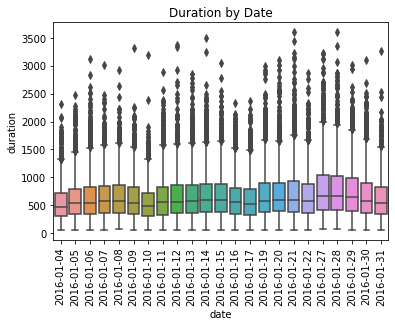

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print(np.mean(train.groupby('date')['duration'].agg(np.mean).values))
ax = sns.boxplot(x = train.date.sort_values(ascending = True), y = 'duration' , data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Duration by Date');

In [5]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'pickup_cluster', 'region'] 

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) 
    categoricals = [pd.get_dummies(t[s], prefix = s, drop_first = True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis = 1)

design_matrix(train).head()

,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,distance,hour_1,hour_2,hour_3,hour_4,hour_5,...,pickup_cluster_2,pickup_cluster_3,pickup_cluster_4,pickup_cluster_5,pickup_cluster_6,pickup_cluster_7,pickup_cluster_8,pickup_cluster_9,region_1,region_2
16548,-0.805821,-0.171761,0.954062,0.624203,0.626326,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
10750,-0.570281,0.077978,-0.231391,0.234068,-0.826569,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
10957,-1.571566,-1.020443,-1.216691,-0.201297,-0.190927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89932,-0.673389,-0.204856,-0.152744,-0.014301,-0.679882,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
54687,1.354249,0.803938,0.897948,0.597992,-1.029136,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [6]:
from sklearn.linear_model import LinearRegression

def rmse(errors):
    return np.sqrt(np.mean(errors ** 2))

def regression_model(train_data, test_data, outcome = 'duration'):
    
    train, test = design_matrix(train_data), design_matrix(test_data)
    y_train, y_test = train_data.duration, test_data.duration
    
    if outcome == 'speed':
        model = LinearRegression().fit(train, train_data.speed)
        predictions = model.predict(test)
        duration_pred = test_data.distance / (predictions / 60 / 60)
        errors = duration_pred - y_test
        return errors
    
    model = LinearRegression().fit(train, y_train)
    predictions = model.predict(test)
    errors = predictions - y_test
    return errors

# Linear Model with Design Matrix features

In [7]:
linear_model = regression_model(train, test)
linear_rmse = rmse(linear_model)
linear_rmse

254.44598181469135

# Model fit to differing Periods of Day

In [8]:
day_period_model = []
for v in np.unique(train.day_period):
    v_train, v_test = train[train.day_period == v], test[test.day_period == v]
    v_error = regression_model(v_train, v_test)
    day_period_model.extend(v_error)
    
day_period_rmse = rmse(np.array(day_period_model))
day_period_rmse

245.46893038310677

# Predict Duration through Modeling Speed

In [9]:
speed_model = regression_model(train, test, outcome = 'speed')
speed_rmse = rmse(speed_model)
speed_rmse

241.90367885130465

# Tree Regression

In [10]:
choices = ['day_period', 'region', 'weekend']

def tree_regression(outcome = 'duration', model = regression_model):
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        
        for v, c in zip(vs, choices):
            v_train = v_train[v_train[c] == v]
            v_test = v_test[v_test[c] == v]
         
        vs_model = model(v_train, v_test, outcome = outcome)
        errors.extend(vs_model)
        
    return errors

tree_model = tree_regression()
speed_tree_model = tree_regression(outcome = 'speed')

tree_rmse, tree_speed_rmse = rmse(np.array(tree_model)), rmse(np.array(speed_tree_model))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.3278972915743 
Speed: 226.65620525928165


# XGBoost

In [11]:
import xgboost as xgb

params = {
    'max_depth': 3,  
    'eta': 0.3,  
    'silent': 1,  
    'eval_metric': 'rmse',
    'objective': 'reg:linear'} 

epochs = 20  


def xgboost_model(train_data, test_data, param = params, epoch = epochs, outcome = 'duration', plot = False):
    
    if outcome == 'speed':
        y_train, y_test = train_data.speed, test_data.speed
        
        dtrain = xgb.DMatrix(design_matrix(train_data), label = y_train)
        dtest = xgb.DMatrix(design_matrix(test_data), label = y_test)
        
        xgb_model = xgb.train(param, dtrain, epoch)
        xgb_preds = xgb_model.predict(dtest)
        
        duration_pred = test_data.distance / (xgb_preds / 60 / 60)
        errors = duration_pred - test_data.duration
        if plot == True:
            xgb.plot_importance(xgb_model, height=0.7)
        return errors
        
  
    y_train, y_test = train_data.duration, test_data.duration
    
    dtrain = xgb.DMatrix(design_matrix(train_data), label = y_train)
    dtest = xgb.DMatrix(design_matrix(test_data), label = y_test)
    
    xgb_model = xgb.train(param, dtrain, epoch)
    xgb_preds = xgb_model.predict(dtest)
    
    errors = xgb_preds - y_test
    
    if plot == True:
        xgb.plot_importance(xgb_model, height=0.7)
    return errors

235.9422673124631

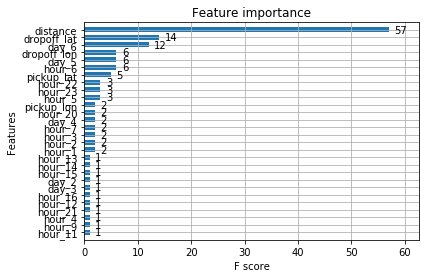

In [12]:
xgb_model = xgboost_model(train, test, plot = True)
xgb_rmse = rmse(xgb_model)
xgb_rmse

240.12693594901228

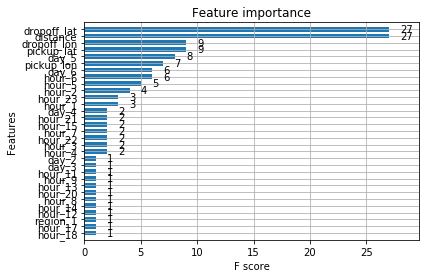

In [13]:
xgb_speed_model = xgboost_model(train, test, outcome = 'speed', plot = True)
xgb_speed_rmse = rmse(xgb_speed_model)
xgb_speed_rmse

In [14]:
xgb_tree_model = tree_regression(model = xgboost_model)
xgb_speed_tree_model = tree_regression(outcome = 'speed', model = xgboost_model)

xgb_tree_rmse, xgb_tree_speed_rmse = rmse(np.array(xgb_tree_model)), rmse(np.array(xgb_speed_tree_model))
print('Duration:', xgb_tree_rmse, '\nSpeed:', xgb_tree_speed_rmse)

Duration: 215.20752216431893 
Speed: 218.74343198996652


# Model Performance Results

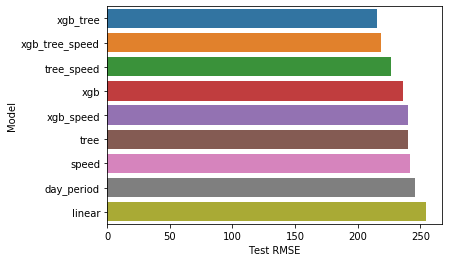

In [15]:
models = ['linear', 'day_period', 'speed', 'tree', 'tree_speed', 'xgb', 'xgb_speed', 'xgb_tree', 'xgb_tree_speed']
model_rmse = pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).sort_values(by  =['Test RMSE']).set_index('Model')

ax = sns.barplot(x = 'Test RMSE', y = model_rmse.index, data = model_rmse)

In [16]:
!pip install xgboost